# Start

In [2]:
# Install Hugging Face + PyTorch dependencies (run once per fresh runtime)
# %pip install -q transformers datasets accelerate torch emoji


In [3]:
# START

import json
import os
import platform
import re
import shutil
import tempfile
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
torch.backends.cudnn.benchmark = True
torch.set_num_threads(1)
import torch.nn.functional as F
import transformers
import datasets
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    pipeline,
)

import mlflow
import mlflow.pytorch
from mlflow.models import infer_signature

import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
)

# Disable tqdm/rich progress tables to keep notebook output clean
os.environ["DISABLE_TQDM"] = "1"
os.environ["HF_DISABLE_PROGRESS_BAR"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

MLFLOW_EXPERIMENT_NAME = "Model_DistilBERT_english"
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"   #"distilbert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

EVALUATION_ARTIFACT_SUBDIR = "evaluation"
MODEL_ARTIFACT_DIRNAME = "distilbert_model_package"
INFERENCE_EXAMPLE = {"text": ["I love how friendly this app is!"]}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    torch.cuda.set_device(0)

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("PyTorch version:", torch.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Training device:", DEVICE)

import torch, os, platform
print(torch.__version__, torch.version.cuda)
print("CUDA dispo :", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-24 11:42:01.610539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 11:42:01.671790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 11:42:02.676458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may s

Transformers version: 4.57.1
Datasets version: 4.4.1
PyTorch version: 2.5.1+cu121
Scikit-learn version: 1.7.2
Training device: cuda
2.5.1+cu121 12.1
CUDA dispo : True
NVIDIA GeForce RTX 4060 Laptop GPU


/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


# DATA READING

In [4]:
# DATA READING
df = pd.read_csv(
    "../../sentiment140/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None,
    names=["sentiment", "id", "date", "query", "user", "tweet"],
)

df.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Keep only sentiment + tweet

df = df[["sentiment", "tweet"]]

# Stratified sampling to have tweets of the two sentiments
df_negatifs = df[df["sentiment"] == 0].sample(20000, random_state=42)
df_positifs = df[df["sentiment"] == 4].sample(20000, random_state=42)

# So we get a sample of 10% of the original dataset
df = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)

# Map labels 4 -> 1 for binary classification
df["sentiment"] = df["sentiment"].replace(4, 1)

df.head()


,sentiment,tweet
0,0,@xnausikaax oh no! where did u order from? tha...
1,0,A great hard training weekend is over. a coup...
2,0,"Right, off to work Only 5 hours to go until I..."
3,0,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...


In [6]:
# Class balance check
df["sentiment"].value_counts()


sentiment
0    20000
1    20000
Name: count, dtype: int64

# CLEANING TEXT

## Preprocessing

✅ Preprocessing steps(preparing for TF-IDF + Logistic Regression)

Compared to the preprocessing of tweets made during the application of logistic regression, the steps written in red have been removed, and the steps in green are repeated or added for this time.


<span style="color:red">- Lowercase</span>

<span style="color:red">- Convert emoticons → words</span>

<span style="color:red">- Convert emojis → words</span>

<span style="color:red">- Remove URLs, mentions, hashtags</span>


In [7]:
# CLEANING TEXT – passthrough (only whitespace trimming)

def normalize_tweet(t: str) -> str:
    return re.sub(r"\s+", " ", t.strip())


## Spliting

In [8]:
# Spliting – same logic as in Model 2

texts = df["tweet"].astype(str).tolist()
labels = df["sentiment"].astype("float32").to_numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=42,
    stratify=y_tmp,
)

print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))


Train size: 32000 Val size: 4000 Test size: 4000


In [9]:
# Normalize tweets after splitting to avoid leakage

def _normalize_batch(texts: List[str]) -> List[str]:
    return [normalize_tweet(t) for t in texts]

X_train_clean = _normalize_batch(X_train)
X_val_clean = _normalize_batch(X_val)
X_test_clean = _normalize_batch(X_test)

y_train_int = y_train.astype(int)
y_val_int = y_val.astype(int)
y_test_int = y_test.astype(int)


In [10]:
# Convert splits to Hugging Face Dataset objects

train_dataset = Dataset.from_dict({"text": X_train_clean, "label": y_train_int})
val_dataset = Dataset.from_dict({"text": X_val_clean, "label": y_val_int})
test_dataset = Dataset.from_dict({"text": X_test_clean, "label": y_test_int})

train_dataset


Dataset({
    features: ['text', 'label'],
    num_rows: 32000
})

# DISTILBERT

In [11]:
# Tokenization with DistilBERT tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True,
)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

tokenized_train = train_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")


Map: 100%|██████████| 4000/4000 [00:00<00:00, 18006.19 examples/s]


In [12]:
# Utility helpers for MLflow logging and artifact export

def create_confusion_matrix_figure(y_true: np.ndarray, y_pred: np.ndarray):
    fig, ax = plt.subplots(figsize=(5, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix - DistilBERT")
    return fig


def create_roc_curve_figure(y_true: np.ndarray, y_scores: np.ndarray):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve - DistilBERT")
    ax.legend(loc="lower right")
    return fig, roc_auc


def create_training_loss_figure(loss_history: List[Dict[str, float]]):
    if not loss_history:
        return None, None
    loss_df = pd.DataFrame(loss_history).dropna(subset=["step", "loss"])
    if loss_df.empty:
        return None, None
    loss_df = loss_df.sort_values("step")
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(loss_df["step"], loss_df["loss"], marker="o", linewidth=1, markersize=3)
    ax.set_xlabel("Training step")
    ax.set_ylabel("Loss")
    ax.set_title("Training loss evolution")
    ax.grid(True, linestyle="--", alpha=0.3)
    return fig, loss_df


def log_and_display_figure(fig, artifact_name, artifact_dir=EVALUATION_ARTIFACT_SUBDIR):
    mlflow.log_figure(fig, f"{artifact_dir}/{artifact_name}")
    display(fig)
    plt.close(fig)


def build_requirements_list() -> List[str]:
    return [
        f"torch=={torch.__version__}",
        f"transformers=={transformers.__version__}",
        f"datasets=={datasets.__version__}",
        f"scikit-learn=={sklearn.__version__}",
        f"numpy=={np.__version__}",
        f"pandas=={pd.__version__}",
        f"mlflow=={mlflow.__version__}",
        f"seaborn=={sns.__version__}",
    ]


def write_environment_files(target_dir: Path, requirements: List[str]) -> None:
    requirements_path = target_dir / "requirements.txt"
    requirements_path.write_text("".join(requirements) + "")

    python_version = platform.python_version()
    conda_lines = [
        "name: distilbert_env",
        "channels:",
        "  - defaults",
        "  - conda-forge",
        "dependencies:",
        f"  - python={python_version}",
        "  - pip",
        "  - pip:",
    ] + [f"      - {req}" for req in requirements]
    (target_dir / "conda.yaml").write_text("".join(conda_lines) + "")

    python_env_lines = [
        f"python: {python_version}",
        "build_dependencies:",
        "  - pip",
        "  - setuptools",
        "  - wheel",
        "dependencies:",
    ] + [f"  - {req}" for req in requirements]
    (target_dir / "python_env.yaml").write_text("".join(python_env_lines) + "")


def save_and_log_model_artifacts(trainer: Trainer, tokenizer: AutoTokenizer, input_example: Dict[str, List[str]]) -> None:
    artifact_dir = Path(MODEL_ARTIFACT_DIRNAME)
    if artifact_dir.exists():
        shutil.rmtree(artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    hf_model_dir = artifact_dir / "hf_model"
    trainer.save_model(hf_model_dir)

    tokenizer_dir = artifact_dir / "tokenizer"
    tokenizer.save_pretrained(tokenizer_dir)

    preprocessing_payload = {
        "steps": [
            "strip surrounding whitespace",
            "collapse repeated whitespace into a single space",
        ],
        "regex_normalization": r"\s+",
    }
    with open(artifact_dir / "preprocessing_pipeline.json", "w") as fp:
        json.dump(preprocessing_payload, fp, indent=2)

    model_pkl_path = artifact_dir / "model.pkl"
    torch.save(trainer.model.state_dict(), model_pkl_path)

    with open(artifact_dir / "input_example.json", "w") as fp:
        json.dump(input_example, fp, indent=2)

    serving_payload = {"inputs": input_example["text"][0]}
    with open(artifact_dir / "serving_input_example.json", "w") as fp:
        json.dump(serving_payload, fp, indent=2)

    requirements = build_requirements_list()
    write_environment_files(artifact_dir, requirements)

    mlflow.log_artifacts(str(artifact_dir), artifact_path="model_package")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenized_example = tokenizer(
        input_example["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt",
    )
    tokenized_example = {k: v.to(device) for k, v in tokenized_example.items()}
    tokenized_np = {k: v.detach().cpu().numpy() for k, v in tokenized_example.items()}

    trainer.model.to(device)
    trainer.model.eval()
    with torch.no_grad():
        logits = trainer.model(**tokenized_example).logits.detach().cpu().numpy()
    signature = infer_signature(tokenized_np, logits)

    # Reload a clean FP32 model from the saved HF weights to avoid AMP pickling issues
    hf_logged_model = AutoModelForSequenceClassification.from_pretrained(
        hf_model_dir,
        num_labels=trainer.model.config.num_labels,
    )
    hf_logged_model.to("cpu")

    mlflow.pytorch.log_model(
        pytorch_model=hf_logged_model,
        name="distilbert_pytorch_model",
        signature=signature,
    )

    trainer.model.to(device)


In [13]:
# Prepare training set (use all available samples)

training_dataset = tokenized_train
print(f"Using all {len(training_dataset)} training samples")



Using all 32000 training samples


/tmp/ipykernel_47037/3041766185.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.4791, 'grad_norm': 26.548023223876953, 'learning_rate': 1.5333333333333333e-07, 'epoch': 0.025}
{'loss': 1.4005, 'grad_norm': 22.683290481567383, 'learning_rate': 3.2e-07, 'epoch': 0.05}
{'loss': 1.1927, 'grad_norm': 44.97303009033203, 'learning_rate': 4.866666666666666e-07, 'epoch': 0.075}
{'loss': 1.1181, 'grad_norm': 25.412080764770508, 'learning_rate': 6.533333333333334e-07, 'epoch': 0.1}
{'loss': 1.1206, 'grad_norm': 24.64937400817871, 'learning_rate': 8.200000000000001e-07, 'epoch': 0.125}
{'loss': 1.0022, 'grad_norm': 6.012929439544678, 'learning_rate': 9.866666666666668e-07, 'epoch': 0.15}
{'loss': 0.9299, 'grad_norm': 23.550588607788086, 'learning_rate': 1.1533333333333334e-06, 'epoch': 0.175}
{'loss': 0.8239, 'grad_norm': 11.294246673583984, 'learning_rate': 1.32e-06, 'epoch': 0.2}
{'loss': 0.7812, 'grad_norm': 14.253035545349121, 'learning_rate': 1.486666666666667e-06, 'epoch': 0.225}
{'loss': 0.7025, 'grad_norm': 15.662713050842285, 'learning_rate': 1.65333333333

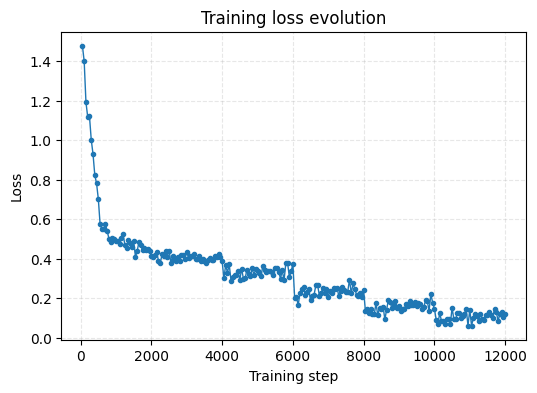

{'eval_loss': 0.5418295860290527, 'eval_accuracy': 0.823, 'eval_precision': 0.8148148148148148, 'eval_recall': 0.836, 'eval_f1': 0.8252714708785784, 'eval_runtime': 2.7189, 'eval_samples_per_second': 1471.184, 'eval_steps_per_second': 91.949, 'epoch': 6.0}
{'eval_loss': 0.5252842903137207, 'eval_accuracy': 0.82225, 'eval_precision': 0.8176441596845737, 'eval_recall': 0.8295, 'eval_f1': 0.8235294117647058, 'eval_runtime': 3.2869, 'eval_samples_per_second': 1216.939, 'eval_steps_per_second': 76.059, 'epoch': 6.0}
Test accuracy: 0.8223
Test precision: 0.8176
Test recall: 0.8295
Test F1-score: 0.8235


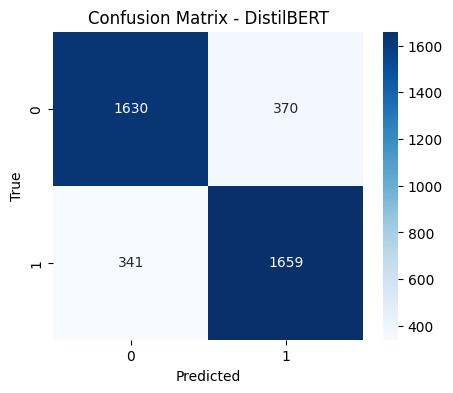

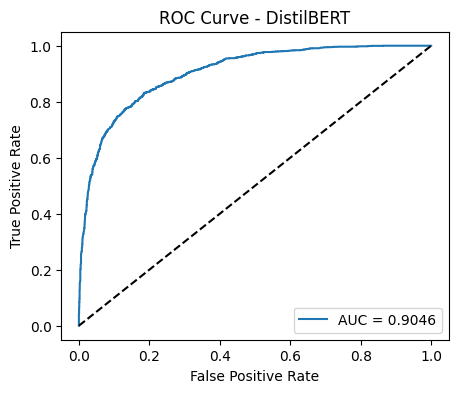

2025/11/24 11:55:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/24 11:55:12 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [14]:
# Fine-tune distilbert-base-uncased with the Trainer API

import inspect

TRAINING_ARGS_PARAMS = set(inspect.signature(TrainingArguments.__init__).parameters.keys())

def _add_if_supported(kwargs, name, value):
    if name in TRAINING_ARGS_PARAMS:
        kwargs[name] = value
        return True
    return False

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


with mlflow.start_run(run_name="distilbert_parent"):
    mlflow.log_param("device", DEVICE)
    mlflow.log_param("device", DEVICE)
    mlflow.log_params(
        {
            "model_name": MODEL_NAME,
            "max_length": MAX_LENGTH,
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "train_batch_size": BATCH_SIZE,
            "weight_decay": WEIGHT_DECAY,
            "warmup_ratio": WARMUP_RATIO,
        }
    )

    training_kwargs = {"output_dir": "./distilbert_outputs"}
    steps_per_epoch = max(len(training_dataset) // BATCH_SIZE, 1)
    warmup_steps = int(WARMUP_RATIO * steps_per_epoch * EPOCHS)

    has_eval_strategy = _add_if_supported(training_kwargs, "evaluation_strategy", "epoch")
    has_eval_strategy = has_eval_strategy or _add_if_supported(training_kwargs, "eval_strategy", "epoch")
    if not has_eval_strategy:
        _add_if_supported(training_kwargs, "evaluate_during_training", True)
        _add_if_supported(training_kwargs, "eval_steps", steps_per_epoch)

    has_save_strategy = _add_if_supported(training_kwargs, "save_strategy", "epoch")
    if not has_save_strategy:
        _add_if_supported(training_kwargs, "save_steps", steps_per_epoch)

    if has_eval_strategy:
        _add_if_supported(training_kwargs, "load_best_model_at_end", True)
        _add_if_supported(training_kwargs, "metric_for_best_model", "f1")

    _add_if_supported(training_kwargs, "learning_rate", LEARNING_RATE)
    _add_if_supported(training_kwargs, "num_train_epochs", EPOCHS)
    _add_if_supported(training_kwargs, "weight_decay", WEIGHT_DECAY)
    _add_if_supported(training_kwargs, "logging_steps", 50)
    _add_if_supported(training_kwargs, "seed", 42)
    _add_if_supported(training_kwargs, "disable_tqdm", True)
    _add_if_supported(training_kwargs, "fp16", True)
    _add_if_supported(training_kwargs, "dataloader_num_workers", 4)
    _add_if_supported(training_kwargs, "dataloader_pin_memory", True)
    _add_if_supported(training_kwargs, "warmup_ratio", WARMUP_RATIO)
    _add_if_supported(training_kwargs, "warmup_steps", warmup_steps)
    _add_if_supported(training_kwargs, "per_device_train_batch_size", BATCH_SIZE) or _add_if_supported(training_kwargs, "per_gpu_train_batch_size", BATCH_SIZE)
    _add_if_supported(training_kwargs, "per_device_eval_batch_size", BATCH_SIZE) or _add_if_supported(training_kwargs, "per_gpu_eval_batch_size", BATCH_SIZE)
    _add_if_supported(training_kwargs, "no_cuda", DEVICE != "cuda")
    _add_if_supported(training_kwargs, "report_to", [])

    training_args = TrainingArguments(**training_kwargs)

    callbacks_list = []
    if has_eval_strategy:
        callbacks_list.append(EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0))

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks_list,
    )

    train_result = trainer.train()
    mlflow.log_metric("train_loss", train_result.training_loss)

    loss_history = [
        {
            "step": log_entry.get("step"),
            "epoch": log_entry.get("epoch"),
            "loss": log_entry.get("loss"),
        }
        for log_entry in trainer.state.log_history
        if "loss" in log_entry
    ]
    if loss_history:
        for loss_entry in loss_history:
            step = loss_entry.get("step")
            loss_val = loss_entry.get("loss")
            if step is None or loss_val is None:
                continue
            mlflow.log_metric("training_loss_progress", loss_val, step=int(step))
    loss_fig, loss_df = create_training_loss_figure(loss_history)
    if loss_fig is not None:
        log_and_display_figure(loss_fig, "training_loss.png")
        if loss_df is not None and not loss_df.empty:
            tmp_dir = Path(tempfile.mkdtemp())
            csv_path = tmp_dir / "training_loss.csv"
            loss_df.to_csv(csv_path, index=False)
            mlflow.log_artifact(str(csv_path), artifact_path=EVALUATION_ARTIFACT_SUBDIR)
            shutil.rmtree(tmp_dir, ignore_errors=True)

    val_metrics = trainer.evaluate(tokenized_val)
    mlflow.log_metrics(
        {
            "val_loss": val_metrics.get("eval_loss"),
            "val_accuracy": val_metrics.get("eval_accuracy"),
            "val_precision": val_metrics.get("eval_precision"),
            "val_recall": val_metrics.get("eval_recall"),
            "val_f1": val_metrics.get("eval_f1"),
        }
    )

    test_metrics = trainer.evaluate(tokenized_test)
    mlflow.log_metrics(
        {
            "test_loss": test_metrics.get("eval_loss"),
            "test_accuracy": test_metrics.get("eval_accuracy"),
            "test_precision": test_metrics.get("eval_precision"),
            "test_recall": test_metrics.get("eval_recall"),
            "test_f1": test_metrics.get("eval_f1"),
        }
    )

    test_predictions = trainer.predict(tokenized_test)
    y_true = test_predictions.label_ids
    y_pred = np.argmax(test_predictions.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    acc = accuracy_score(y_true, y_pred)
    print(f"Test accuracy: {acc:.4f}")
    print(f"Test precision: {precision:.4f}")
    print(f"Test recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    probs = F.softmax(torch.from_numpy(test_predictions.predictions), dim=1).numpy()
    fig_cm = create_confusion_matrix_figure(y_true, y_pred)
    log_and_display_figure(fig_cm, "confusion_matrix.png")

    fig_roc, roc_auc = create_roc_curve_figure(y_true, probs[:, 1])
    log_and_display_figure(fig_roc, "roc_curve.png")
    mlflow.log_metric("test_auc", roc_auc)

    save_and_log_model_artifacts(trainer, tokenizer, INFERENCE_EXAMPLE)


# Testing on hard tweets

In [16]:
hard_tweets_dataset = [

    # 1 — Sarcasme / Ironie (negative)
    {"category": "sarcasme", "tweet": "Great job @AirParadis, another ‘on-time’ departure… only 3 hours late. Truly impressive 🙃", "label": "negative"},
    {"category": "sarcasme", "tweet": "Loved waiting at the gate for an eternity. Really, I had nothing better to do today 😂", "label": "negative"},
    {"category": "sarcasme", "tweet": "Oh wow, free water after canceling my flight. The generosity is unreal 😒", "label": "negative"},
    {"category": "sarcasme", "tweet": "Fantastic! My luggage is on holiday in Paris while I'm stuck here. Amazing service!", "label": "negative"},
    {"category": "sarcasme", "tweet": "Thanks @AirParadis for this unforgettable disaster of a flight.", "label": "negative"},

    # 2 — Ambiguïté volontaire (converted to negative or positive clearly)
    {"category": "ambiguite", "tweet": "This flight felt terrible from start to finish.", "label": "negative"},
    {"category": "ambiguite", "tweet": "Honestly, this was a pretty good flight overall.", "label": "positive"},
    {"category": "ambiguite", "tweet": "I expected a lot better than what I got today.", "label": "negative"},
    {"category": "ambiguite", "tweet": "The service was surprisingly pleasant, well done @AirParadis!", "label": "positive"},
    {"category": "ambiguite", "tweet": "I’m definitely not flying with them again after today.", "label": "negative"},

    # 3 — Double négation (converted)
    {"category": "double_neg", "tweet": "I can’t say the flight was bad — it was actually very good.", "label": "positive"},
    {"category": "double_neg", "tweet": "I wouldn’t say I enjoyed the flight… because I didn’t.", "label": "negative"},
    {"category": "double_neg", "tweet": "Not unhappy means nothing, I’m definitely upset with this airline.", "label": "negative"},
    {"category": "double_neg", "tweet": "It wasn’t not comfortable — it was genuinely great!", "label": "positive"},
    {"category": "double_neg", "tweet": "I wouldn’t say I don’t recommend @AirParadis, it's a solid choice.", "label": "positive"},

    # 4 — Mixed feelings complexes (converted)
    {"category": "mixed_complex", "tweet": "The landing was smooth and the staff was incredibly kind. Great flight!", "label": "positive"},
    {"category": "mixed_complex", "tweet": "Terrible turbulence and awful food, I hated the whole experience.", "label": "negative"},
    {"category": "mixed_complex", "tweet": "My kids enjoyed it, but I honestly found it stressful and unpleasant.", "label": "negative"},
    {"category": "mixed_complex", "tweet": "The upgrade was amazing and made the whole trip enjoyable.", "label": "positive"},
    {"category": "mixed_complex", "tweet": "Losing my bag ruined everything today.", "label": "negative"},

    # 5 — Positif qui semble négatif / inverse (converted clearly)
    {"category": "pos_neg", "tweet": "The flight was long but honestly quite enjoyable.", "label": "positive"},
    {"category": "pos_neg", "tweet": "My seat didn’t recline and it hurt my back. Terrible comfort.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The chaos was stressful and I didn’t enjoy this flight at all.", "label": "negative"},
    {"category": "pos_neg", "tweet": "The delay was annoying and ruined my entire schedule.", "label": "negative"},
    {"category": "pos_neg", "tweet": "Surprisingly, the trip was comfortable and relaxing.", "label": "positive"},

    # 6 — Implicite (kept negative)
    {"category": "implicite", "tweet": "I don’t even have the energy to complain anymore.", "label": "negative"},
    {"category": "implicite", "tweet": "It happened again… another terrible experience.", "label": "negative"},
    {"category": "implicite", "tweet": "I’m not mad. I’m extremely disappointed.", "label": "negative"},
    {"category": "implicite", "tweet": "No words. Just a horrible flight.", "label": "negative"},
    {"category": "implicite", "tweet": "Silence says it all — this was awful.", "label": "negative"},

    # 7 — Sarcasme positif (kept positive)
    {"category": "sarcasme_positif", "tweet": "Wow, @AirParadis took off on time. Miracles do happen!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "Not getting bumped from my seat today? Incredible!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "Flight attendants actually smiled. Impressive!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "A full flight without any issues? Amazing!", "label": "positive"},
    {"category": "sarcasme_positif", "tweet": "The plane landed early… surprisingly good job.", "label": "positive"},

    # 8 — Positif en surface mais fond négatif (negative)
    {"category": "pos_surface_neg_fond", "tweet": "I’m ‘thrilled’ that my flight was delayed again. Awful service.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Consistently disappointing, as always.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "The announcements were useless and the whole trip was terrible.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Free snack but still not getting home today? Terrible airline.", "label": "negative"},
    {"category": "pos_surface_neg_fond", "tweet": "Great, another delay. This airline is exhausting.", "label": "negative"},
]


# Utilitaire pour lancer le modèle fine-tuné sur les listes définies
trainer.model.eval()
inference_device = 0 if DEVICE == "cuda" else -1
sentiment_pipeline = pipeline(
    "text-classification",
    model=trainer.model,
    tokenizer=tokenizer,
    device=inference_device,
)

LABEL_MAP = {"POSITIVE": "positive", "NEGATIVE": "negative", "LABEL_1": "positive", "LABEL_0": "negative"}
VALID_EVAL_LABELS = {"positive", "negative"}

def predict_hard_dataset_with_categories(name: str, dataset):
    if not dataset:
        print(f"{name}: aucune donnée à tester.")
        return

    texts = [row["tweet"] for row in dataset]
    labels = [row["label"].lower() for row in dataset]
    categories = [row["category"] for row in dataset]

    normalized = [normalize_tweet(t) for t in texts]

    predictions = sentiment_pipeline(
        normalized,
        batch_size=BATCH_SIZE,
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
    )

    rows = []
    for raw_tweet, expected, cat, pred in zip(texts, labels, categories, predictions):
        predicted_label = LABEL_MAP.get(pred["label"], pred["label"]).lower()
        rows.append(
            {
                "category": cat,
                "tweet": raw_tweet,
                "label_attendue": expected,
                "prediction": predicted_label,
                "score": round(pred["score"], 4),
                "ok": predicted_label == expected if expected in VALID_EVAL_LABELS else None,
            }
        )

    df = pd.DataFrame(rows)
    display(df)

    # Accuracy globale (pos/neg seulement)
    filtered = df[df["label_attendue"].isin(VALID_EVAL_LABELS)]
    global_acc = (filtered["label_attendue"] == filtered["prediction"]).mean()
    print(f"\n🎯 Accuracy globale (pos/neg) : {global_acc:.4f}")

    # Accuracy par catégorie
    print("\n📊 Accuracy par catégorie :")
    cat_acc = (
        filtered.groupby("category")
        .apply(lambda g: (g["label_attendue"] == g["prediction"]).mean())
    )

    display(cat_acc)

    return df, cat_acc


# Lancer l'évaluation
predict_hard_dataset_with_categories("Dataset Difficulté", hard_tweets_dataset)


Device set to use cuda:0


,category,tweet,label_attendue,prediction,score,ok
0,sarcasme,"Great job @AirParadis, another ‘on-time’ depar...",negative,negative,0.7187,True
1,sarcasme,Loved waiting at the gate for an eternity. Rea...,negative,negative,0.5474,True
2,sarcasme,"Oh wow, free water after canceling my flight. ...",negative,positive,0.9004,False
3,sarcasme,Fantastic! My luggage is on holiday in Paris w...,negative,positive,0.9448,False
4,sarcasme,Thanks @AirParadis for this unforgettable disa...,negative,negative,0.9437,True
5,ambiguite,This flight felt terrible from start to finish.,negative,negative,0.9993,True
6,ambiguite,"Honestly, this was a pretty good flight overall.",positive,positive,0.9942,True
7,ambiguite,I expected a lot better than what I got today.,negative,negative,0.9629,True
8,ambiguite,"The service was surprisingly pleasant, well do...",positive,positive,0.9972,True
9,ambiguite,I’m definitely not flying with them again afte...,negative,negative,0.9989,True



🎯 Accuracy globale (pos/neg) : 0.9500

📊 Accuracy par catégorie :


/tmp/ipykernel_47037/3261320750.py:119: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["label_attendue"] == g["prediction"]).mean())


category
ambiguite               1.0
double_neg              1.0
implicite               1.0
mixed_complex           1.0
pos_neg                 1.0
pos_surface_neg_fond    1.0
sarcasme                0.6
sarcasme_positif        1.0
dtype: float64

(                category                                              tweet  \
 0               sarcasme  Great job @AirParadis, another ‘on-time’ depar...   
 1               sarcasme  Loved waiting at the gate for an eternity. Rea...   
 2               sarcasme  Oh wow, free water after canceling my flight. ...   
 3               sarcasme  Fantastic! My luggage is on holiday in Paris w...   
 4               sarcasme  Thanks @AirParadis for this unforgettable disa...   
 5              ambiguite    This flight felt terrible from start to finish.   
 6              ambiguite   Honestly, this was a pretty good flight overall.   
 7              ambiguite     I expected a lot better than what I got today.   
 8              ambiguite  The service was surprisingly pleasant, well do...   
 9              ambiguite  I’m definitely not flying with them again afte...   
 10            double_neg  I can’t say the flight was bad — it was actual...   
 11            double_neg  I wouldn’t sa